<a href="https://colab.research.google.com/github/premanshsharma/Multilingual-Abusive-Comment-Detection/blob/main/NNMultilingualAbusiveCommentDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import re
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [4]:
import pandas as pd
link = '/content/gdrive/MyDrive/ShareChat-IndoML-Datathon-NSFW-CommentChallenge_Test_NoLabel.csv/ShareChat-IndoML-Datathon-NSFW-CommentChallenge_Train.csv'
df = pd.read_csv(link, error_bad_lines=False, encoding='utf-8')

<ipython-input-4-3717ab4b4984>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(link, error_bad_lines=False, encoding='utf-8')
b'Skipping line 446: expected 10 fields, saw 13\nSkipping line 614: expected 10 fields, saw 11\nSkipping line 2576: expected 10 fields, saw 13\nSkipping line 2762: expected 10 fields, saw 18\nSkipping line 3384: expected 10 fields, saw 11\nSkipping line 3831: expected 10 fields, saw 11\nSkipping line 3892: expected 10 fields, saw 12\nSkipping line 4037: expected 10 fields, saw 11\nSkipping line 4042: expected 10 fields, saw 12\nSkipping line 4739: expected 10 fields, saw 16\nSkipping line 4846: expected 10 fields, saw 11\nSkipping line 5306: expected 10 fields, saw 11\nSkipping line 6271: expected 10 fields, saw 16\nSkipping line 7853: expected 10 fields, saw 11\nSkipping line 8970: expected 10 fields, saw 11\nSkipping line 9937: expected 10 fields, s

In [5]:
k =['CommentId', 'language', 'user_index', 'post_index','report_count_comment','report_count_post','like_count_comment','like_count_post']
for col in df.columns:
    if col in k:
        del df[col]
len(df[df['label'] == 1])

347390

In [6]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [7]:
def create_word_cloud(df):
    comment_words = ''
    stopwords = set(STOPWORDS)

    # iterate through the csv file
    for val in df['commentText']:
        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens) + " "

    comment_words = remove_emojis(comment_words)

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='black',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

In [ ]:
abusive_df = df[df['label'] == 1]
create_word_cloud(abusive_df)

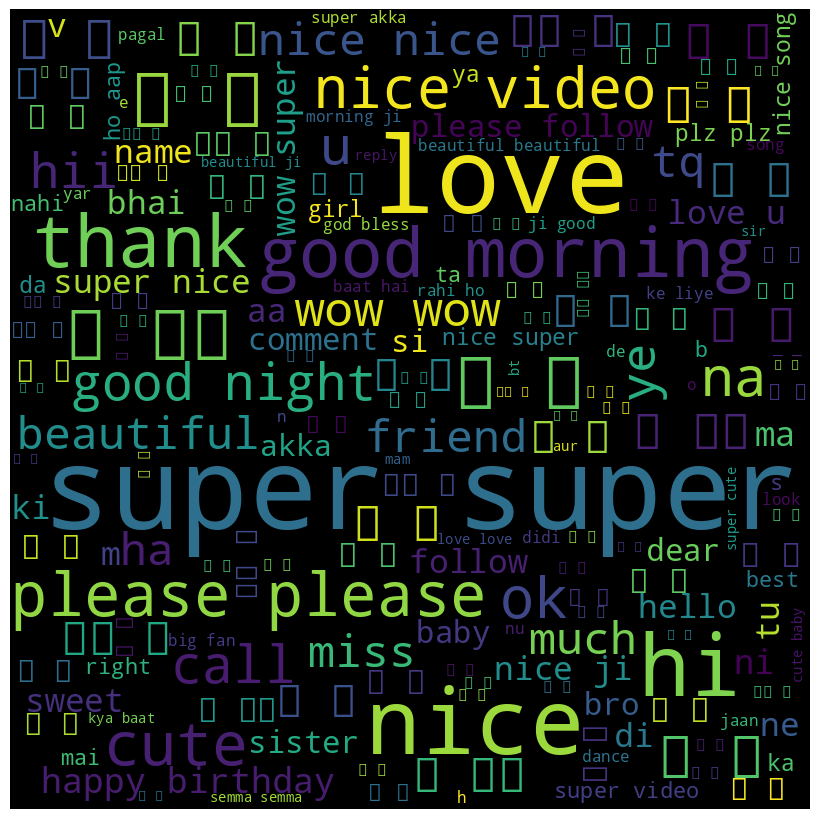

In [9]:
nonabusive_df = df[df['label'] == 0]
create_word_cloud(nonabusive_df)

## TF-IDF Vectorizer

In [9]:
df.isna().sum()

commentText      1
label          219
dtype: int64

In [10]:
df = df.dropna()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df['commentText'][:10000], df['label'][:10000], test_size=0.2, stratify=df['label'][:10000], random_state=42)

In [24]:
vectorizer = TfidfVectorizer(stop_words=['english'])
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

##Classifier

In [28]:
X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state= 8)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)
print(y_train)

[1. 0. 0. ... 0. 0. 0.]


### Neural Networks

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

In [33]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# define the model architecture
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])
# x_val = x_val.toarray()
# X_test = X_test.toarray()
# train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(x_val, y_val), callbacks=[es])

# evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss: {:.3f}".format(loss))
print("Test accuracy: {:.3f}".format(accuracy))

Epoch 1/100
175/175 [==============================] - 10s 54ms/step - loss: 0.6341 - accuracy: 0.6779 - val_loss: 0.5684 - val_accuracy: 0.6900
Epoch 2/100
175/175 [==============================] - 9s 51ms/step - loss: 0.5009 - accuracy: 0.7188 - val_loss: 0.4379 - val_accuracy: 0.8004
Epoch 3/100
175/175 [==============================] - 8s 46ms/step - loss: 0.3193 - accuracy: 0.8864 - val_loss: 0.3488 - val_accuracy: 0.8504
Epoch 4/100
175/175 [==============================] - 9s 51ms/step - loss: 0.1921 - accuracy: 0.9345 - val_loss: 0.3309 - val_accuracy: 0.8625
Epoch 5/100
175/175 [==============================] - 8s 43ms/step - loss: 0.1224 - accuracy: 0.9657 - val_loss: 0.3325 - val_accuracy: 0.8625
Epoch 6/100
175/175 [==============================] - 9s 54ms/step - loss: 0.0801 - accuracy: 0.9791 - val_loss: 0.3403 - val_accuracy: 0.8637
Epoch 7/100
175/175 [==============================] - 7s 41ms/step - loss: 0.0577 - accuracy: 0.9864 - val_loss: 0.3529 - val_accuracy

###Logistic Regression

In [ ]:
clf = LogisticRegression(max_iter=200)
clf = clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
pred = clf.predict(X_test)

In [ ]:
print('accuracy_score:', accuracy_score(y_test, pred))
print('precision_score:', precision_score(y_test, pred))
print('recall_score:', recall_score(y_test, pred))
print('f1_score:', f1_score(y_test, pred))

accuracy_score: 0.9170324076883145
precision_score: 0.87371928363182
recall_score: 0.7548432597368951
f1_score: 0.8099426268117341


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,pred)
cm

array([[219600,   7580],
       [ 17033,  52445]])

### Random Forest Classifier

In [ ]:
clf = RandomForestClassifier(max_depth=50)
clf = clf.fit(X_train, y_train)

In [ ]:
pred = clf.predict(X_test)

In [ ]:
print('accuracy_score:', accuracy_score(y_test, pred))
print('precision_score:', precision_score(y_test, pred))
print('recall_score:', recall_score(y_test, pred))
print('f1_score:', f1_score(y_test, pred))

accuracy_score: 0.7698730524711958
precision_score: 0.9248067463106114
recall_score: 0.018941247589164916
f1_score: 0.03712218445438006


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,pred)
cm

array([[227073,    107],
       [ 68162,   1316]])